In [3]:
#-----------------------------------------------------------------------------#
# Copyright (c) 
#-----------------------------------------------------------------------------#

__authors__  = "Han Xu - HEPS B4 Beamline & PETRA III P10 Beamline"
__date__     = "Date : Thu Apr 14 12:07:33 2022"
__email__    = "xuhan@ihep.ac.cn" 


"""
Description: a pytorch version of PhysenNet
"""

#-----------------------------------------------------------------------------#
# modules

import os
import math

import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import cv2
import tensorboardX

import torch.nn as nn
import random
#------------------------------------------------------------------------------
# parameters

torch.pi = math.pi

# set device

torch.manual_seed(1)
print(torch.__version__)
current_dir = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_writer = tensorboardX.SummaryWriter("./logs/hashtest/")
log_iter = 10

# diffraction data

file_name = "diff_1.tif"
shape = [256, 256]
diffraction = np.array(plt.imread('diff_1.tif'))
diffraction = diffraction[280 : 280 + shape[0], 225 : 225 + shape[1]] 
diffraction = diffraction / np.max(diffraction)

#set seed

random_seed = 42

random.seed(random_seed)  
np.random.seed(random_seed)  
torch.manual_seed(random_seed) 

 
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True


#------------------------------------------------------------------------------
# dataset

class sample_dataset(torch.utils.data.Dataset):
    
    def __init__(
            self, sample, list_ID, count, batch_size = 1, epoch = None, 
            noise_level = 0.03
            ):
        
        self.sample = np.array(sample)
        self.list_ID = list_ID
        self.noise_level = noise_level
        self.shape = np.shape(self.sample)
        self.count = count
        self.batch_size = batch_size
    
    def __len__(self):
        
        return self.count
    
    def __getitem__(self, index):
        
        noise = np.random.uniform(0, self.noise_level, size = self.shape)
        feature = np.reshape(
            np.array(self.sample + noise), 
            (self.batch_size, 1, self.shape[0], self.shape[1])
            )
        
        return torch.tensor(feature).float()

#------------------------------------------------------------------------------
# function

def _fresnel_dfft(
        inpt,  wavelength, nx, ny, xstart, ystart, xend, yend, distance
        ):

    inpt = torch.exp(1j * inpt) 

    # wave number k
    wave_num = 2*torch.pi / wavelength
    
    # the axis in frequency space
    qx = torch.linspace(0.25/xstart, 0.25/xend, nx) * nx
    qy = torch.linspace(0.25/ystart, 0.25/yend, ny) * ny
    
    mesh_qx, mesh_qy = torch.meshgrid(qx, qy)
    
    # the propagation function
    impulse_q = np.exp(
        (1j * wave_num * distance) * 
        (1 - wavelength**2 * (mesh_qx**2 + mesh_qy**2))/2
        )
    
    inpt.to(device)
    impulse_q.to(device)
    
    part1 = torch.fft.fft2(inpt).to(device)
    part2 = torch.fft.ifftshift(impulse_q).to(device)
    
    diffraction = torch.fft.ifft2(part1 * part2)
    intensity = torch.abs(diffraction) * torch.abs(diffraction)
    
    return intensity / torch.max(intensity)

#------------------------------------------------------------------------------
# class

class net_model(torch.nn.Module):
    
    def __init__(self,
                 feature,
                 hash_mod=True):
        
        super(net_model, self).__init__()
        self.hash_mod = hash_mod
        self.feature = nn.parameter.Parameter(feature ,requires_grad = True)
        
        self.layer_01 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                1, 32, (3, 3), stride = (1, 1), padding = 0
                ),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            
            torch.nn.Conv2d(32, 32, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU()
            )
        
        self.layer_01_maxpool = torch.nn.MaxPool2d(
            kernel_size = (2, 2), stride = (2, 2)
            )
        
        self.layer_02 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(),
            
            torch.nn.Conv2d(64, 64, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU()
            )
        
        self.layer_02_maxpool = torch.nn.MaxPool2d(
            kernel_size = (2, 2), stride = (2, 2)
            )
        
        self.layer_03 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(),
            
            torch.nn.Conv2d(128, 128, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU()
            )
        
        self.layer_03_maxpool = torch.nn.MaxPool2d(
            kernel_size = (2, 2), stride = (2, 2)
            )
        
        self.layer_04 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(),
            
            torch.nn.Conv2d(256, 256, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU()
            )
        
        self.layer_04_maxpool = torch.nn.MaxPool2d(
            kernel_size = (2, 2), stride = (2, 2)
            )
        
        self.layer_05 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(),
            
            torch.nn.Conv2d(512, 512, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU()
            )
        
        self.layer_part1 = torch.nn.Sequential(
            self.layer_01, self.layer_01_maxpool, 
            self.layer_02, self.layer_02_maxpool, 
            self.layer_03, self.layer_03_maxpool, 
            self.layer_04, self.layer_04_maxpool, self.layer_05
            )
        
        #-------------------------------------------------------

        # layer_06
        
        self.layer_06_01 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                512, 256, (3, 3), stride = (2, 2), padding = 1, 
                output_padding = 1
                ),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU()
            )
            
        self.layer_06_02 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU()
            )
        
        self.layer_06_03 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU()
            )
        
        # layer_07
        
        self.layer_07_01 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                256, 128, (3, 3), stride = (2, 2), padding = 1, 
                output_padding = 1
                ),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU()
            )
            
        self.layer_07_02 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU()
            )
        
        self.layer_07_03 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU()
            )
        
        # layer_08
        
        self.layer_08_01 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                128, 64, (3, 3), stride = (2, 2), padding = 1, 
                output_padding = 1
                ),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU()
            )
            
        self.layer_08_02 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU()
            )
        
        self.layer_08_03 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU()
            )
        
        # layer_09
        
        self.layer_09_01 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                64, 32, (3, 3), stride = (2, 2), padding = 1, 
                output_padding = 1
                ),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU()
            )
            
        self.layer_09_02 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, (3, 3), stride = (1, 1), padding = 0),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU()
            )
        
        self.layer_09_03 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, (3, 3), stride = (1, 1), padding = 2),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU()
            )
        
        # layer_10
        
        self.layer_10 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 1, (3, 3), stride = (1, 1), padding = 1),
            torch.nn.BatchNorm2d(1),
            torch.nn.LeakyReLU()
            )
        
    def forward(self, x):

        if self.hash_mod:
            #-------------------------------------------------------
            x6_0 = self.layer_06_01(self.layer_part1(self.feature))
            x6_1 = self.layer_04(
                self.layer_03_maxpool(self.layer_03(self.layer_02_maxpool(
                    self.layer_02(self.layer_01_maxpool(self.layer_01(self.feature)))
                    )))
                )
            x6_2 = torch.cat((x6_0, x6_1), 1)
            x6 = self.layer_06_03(self.layer_06_02(x6_2))
            
            #-------------------------------------------------------
            x7_0 = self.layer_07_01(x6)
            x7_1 = self.layer_03(self.layer_02_maxpool(
                self.layer_02(self.layer_01_maxpool(self.layer_01(self.feature)))
                ))
            x7_2 = torch.cat((x7_0, x7_1), 1)
            x7 = self.layer_07_03(self.layer_07_02(x7_2))
            
            #-------------------------------------------------------
            x8_0 = self.layer_08_01(x7)
            x8_1 = self.layer_02(self.layer_01_maxpool(self.layer_01(self.feature)))
            x8_2 = torch.cat((x8_0, x8_1), 1)
            x8 = self.layer_08_03(self.layer_08_02(x8_2))
            
            #-------------------------------------------------------
            x9_0 = self.layer_09_01(x8)
            x9_1 = self.layer_01(self.feature)
            x9_2 = torch.cat((x9_0, x9_1), 1)
            x9 = self.layer_09_03(self.layer_09_02(x9_2))
            
            #-------------------------------------------------------
            x10 = self.layer_10(x9)
        else:
            #-------------------------------------------------------
            x6_0 = self.layer_06_01(self.layer_part1(x))
            x6_1 = self.layer_04(
                self.layer_03_maxpool(self.layer_03(self.layer_02_maxpool(
                    self.layer_02(self.layer_01_maxpool(self.layer_01(x)))
                    )))
                )
            x6_2 = torch.cat((x6_0, x6_1), 1)
            x6 = self.layer_06_03(self.layer_06_02(x6_2))
            
            #-------------------------------------------------------
            x7_0 = self.layer_07_01(x6)
            x7_1 = self.layer_03(self.layer_02_maxpool(
                self.layer_02(self.layer_01_maxpool(self.layer_01(x)))
                ))
            x7_2 = torch.cat((x7_0, x7_1), 1)
            x7 = self.layer_07_03(self.layer_07_02(x7_2))
            
            #-------------------------------------------------------
            x8_0 = self.layer_08_01(x7)
            x8_1 = self.layer_02(self.layer_01_maxpool(self.layer_01(x)))
            x8_2 = torch.cat((x8_0, x8_1), 1)
            x8 = self.layer_08_03(self.layer_08_02(x8_2))
            
            #-------------------------------------------------------
            x9_0 = self.layer_09_01(x8)
            x9_1 = self.layer_01(x)
            x9_2 = torch.cat((x9_0, x9_1), 1)
            x9 = self.layer_09_03(self.layer_09_02(x9_2))
            
            #-------------------------------------------------------
            x10 = self.layer_10(x9)

        
        return x10
        
#------------------------------------------------------------------------------
# main

if __name__ == "__main__":
    
    #---------------------------------------------------------
    # dataset
    
    data = sample_dataset(diffraction, "training", 2000, 1, noise_level = 0.03)
    train_data = torch.utils.data.DataLoader(
        data, batch_size = 2000, shuffle = True
        )
    init_train_data = torch.utils.data.DataLoader(
        data, batch_size = 1, shuffle = False
        )
    for init_train_iter in init_train_data:
        init_feature = init_train_iter.squeeze(0)
    #---------------------------------------------------------
    # net 
    
    net = net_model(feature= init_feature).to(device)
    
    #---------------------------------------------------------
    # loss function
    
    target = torch.tensor(diffraction)
    target = target.to(device)
    loss_fn = torch.nn.MSELoss()
    
    #---------------------------------------------------------
    # optimization 
    
    lr, num_epochs = 0.01, 1
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    index = 0
    iteration = 0
    
    for train_iter in train_data:
        
        for feature in train_iter:
            
            feature = feature.to(device)
            pred_y = net(feature)
            
            #-------------------------------------------------
            # proapation part
            
            measured_y = _fresnel_dfft( 
                pred_y[0, 0, :, :], 632.8e-6, 256, 256, -8e-3 * 128, -8e-3 * 128, 
                8e-3 * 128, 8e-3 * 128, 22.3
                )
            
            #-------------------------------------------------
                
            loss_value = loss_fn(measured_y.float(), target.float())
            # print(loss_value)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            #-------------------------------------------------

            iteration = iteration+1
            if (iteration) % log_iter == 0: 
                train_psnr = -10 * torch.log10(2 * loss_value).item()
                train_loss = loss_value.item()

                train_writer.add_scalar('train_loss', train_loss, iteration)
                train_writer.add_scalar('train_psnr', train_psnr, iteration)
                estimated = torch.abs(measured_y)
                gt = torch.from_numpy(diffraction)
                pred = pred_y[0, 0, :, :]
                train_writer.add_image('estimated_diff', estimated, iteration, dataformats='HW')
                train_writer.add_image('gt', gt, iteration, dataformats='HW')
                train_writer.add_image('estimated_phase', pred, iteration, dataformats='HW')

                print("[Iteration: {}/{}] Train loss: {:.4g} | Train psnr: {:.4g}".format(iteration, 2000, train_loss, train_psnr))


    # #---------------------------------------------------------
    # # visualization
    
    # fig, axes = plt.subplots(1, 3, figsize = (12, 4))
    # axes[0].imshow(diffraction)
    # axes[0].set_title("raw_diff")
    # cv2.imwrite('./raw_diff.png', diffraction*255)

    # estimated_diff = np.abs(measured_y.to("cpu").detach().numpy())
    # axes[1].imshow(estimated_diff)
    # axes[1].set_title("estimated_diff")
    # cv2.imwrite('./estimated_diff_test_origin.png', estimated_diff*255)

    # estimated_phase = pred_y.to("cpu").detach().numpy()[0, 0, :, :]
    # axes[2].imshow(estimated_phase)
    # axes[2].set_title("estimated_phase")
    # cv2.imwrite('./rstimated_phase_test_origin.png', estimated_phase*255)
    
    # fig.tight_layout()


1.9.0+cu111
[Iteration: 10/2000] Train loss: 0.0244 | Train psnr: 13.12
[Iteration: 20/2000] Train loss: 0.0178 | Train psnr: 14.48
[Iteration: 30/2000] Train loss: 0.01396 | Train psnr: 15.54
[Iteration: 40/2000] Train loss: 0.01157 | Train psnr: 16.36
[Iteration: 50/2000] Train loss: 0.01087 | Train psnr: 16.63
[Iteration: 60/2000] Train loss: 0.01025 | Train psnr: 16.88
[Iteration: 70/2000] Train loss: 0.009694 | Train psnr: 17.12
[Iteration: 80/2000] Train loss: 0.009141 | Train psnr: 17.38
[Iteration: 90/2000] Train loss: 0.008578 | Train psnr: 17.66
[Iteration: 100/2000] Train loss: 0.008263 | Train psnr: 17.82
[Iteration: 110/2000] Train loss: 0.007735 | Train psnr: 18.11
[Iteration: 120/2000] Train loss: 0.007463 | Train psnr: 18.26
[Iteration: 130/2000] Train loss: 0.007543 | Train psnr: 18.21
[Iteration: 140/2000] Train loss: 0.006757 | Train psnr: 18.69
[Iteration: 150/2000] Train loss: 0.006108 | Train psnr: 19.13
[Iteration: 160/2000] Train loss: 0.005498 | Train psnr: 19.

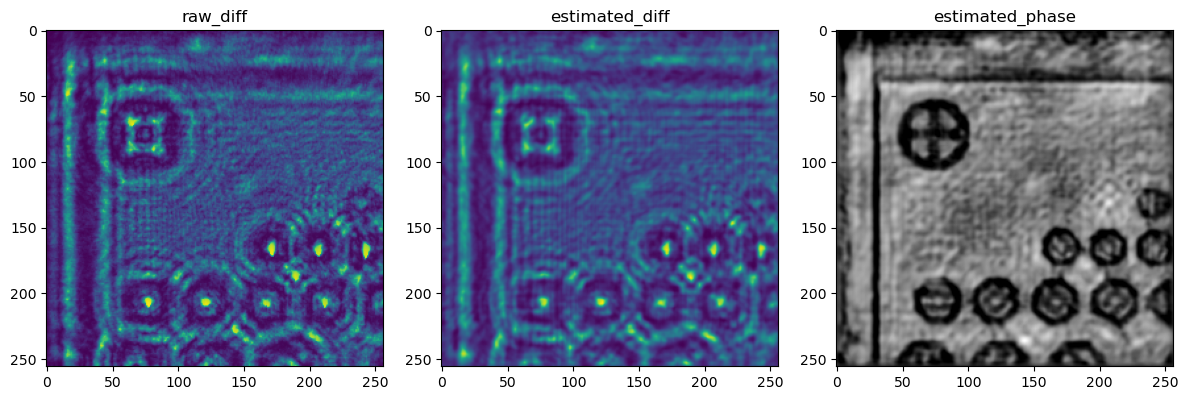

In [2]:
# visualization

fig, axes = plt.subplots(1, 3, figsize = (12, 4))
axes[0].imshow(diffraction)
axes[0].set_title("raw_diff")
cv2.imwrite('./raw_diff.png', diffraction*255)

estimated_diff = np.abs(measured_y.to("cpu").detach().numpy())
axes[1].imshow(estimated_diff)
axes[1].set_title("estimated_diff")


estimated_phase = pred_y.to("cpu").detach().numpy()[0, 0, :, :]
axes[2].imshow(estimated_phase,cmap=plt.cm.gray)
axes[2].set_title("estimated_phase")

fig.tight_layout()


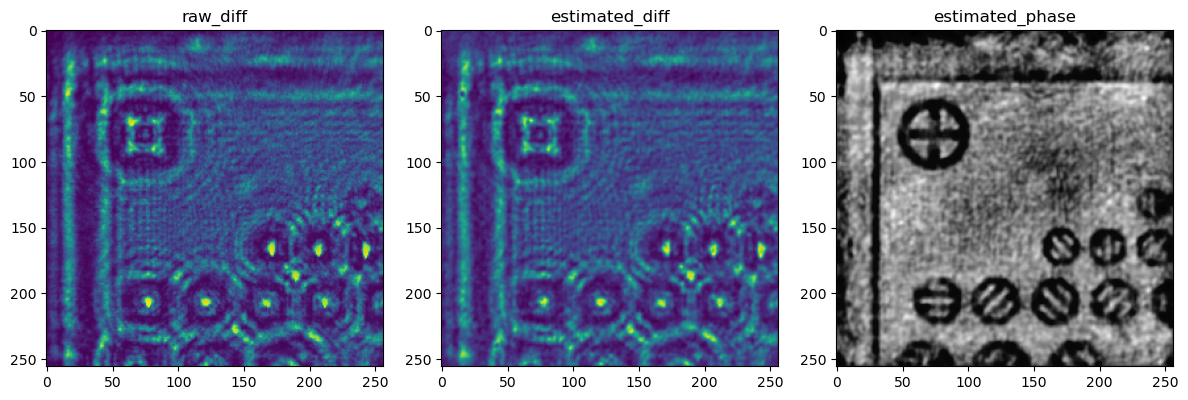

In [4]:
# visualization

fig, axes = plt.subplots(1, 3, figsize = (12, 4))
axes[0].imshow(diffraction)
axes[0].set_title("raw_diff")
cv2.imwrite('./raw_diff.png', diffraction*255)

estimated_diff = np.abs(measured_y.to("cpu").detach().numpy())
axes[1].imshow(estimated_diff)
axes[1].set_title("estimated_diff")


estimated_phase = pred_y.to("cpu").detach().numpy()[0, 0, :, :]
axes[2].imshow(estimated_phase,cmap=plt.cm.gray)
axes[2].set_title("estimated_phase")

fig.tight_layout()